# Import Library

In [ ]:
!pip install pandas numpy matplotlib seaborn statsmodels lifelines
!pip install --upgrade openpyxl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from lifelines import KaplanMeierFitter

## Load the data for inflation
https://data.bls.gov/timeseries/CUUR0000SA0L1E?output_view=pct_12mths

In [3]:
cpi_df = pd.read_excel('./SeriesReport-20250410235943_836898.xlsx', skiprows= 11)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
# Calculate annual average inflation rate
cpi_df['Inflation_Rate'] = (cpi_df['HALF1'] + cpi_df['HALF2']) / 2

# Initialize CPI Index with 2024 as base (100)
cpi_index = [None] * len(cpi_df)
base_year_idx = cpi_df[cpi_df['Year'] == 2024].index[0]
cpi_index[base_year_idx] = 100.0

# Backward calculation (2023 → 2015)
for i in range(base_year_idx - 1, -1, -1):
    cpi_index[i] = cpi_index[i + 1] / (1 + cpi_df.loc[i, 'Inflation_Rate'] / 100)


# Forward calculation (2025)
if 2025 in cpi_df['Year'].values:
    jan_2025_inflation = cpi_df.loc[cpi_df['Year'] == 2025, 'Jan'].values[0]
    cpi_index[base_year_idx + 1] = cpi_index[base_year_idx] * (1 + jan_2025_inflation / 100)

cpi_df['CPI_Index'] = cpi_index

cpi_df = cpi_df[['Year', 'CPI_Index']]

## Load the data

In [5]:
df_rfm = pd.read_excel('./output.xlsx')
df_rfm = df_rfm.rename(columns={'id': 'ID'})

In [6]:
df_transactions = pd.read_excel('./data/all_transactions.xlsx')
df_transactions = df_transactions.rename(columns={'Revenue Amount': 'Revenue', 'Account Number': 'ID'})

In [7]:
df = df_transactions.merge(df_rfm, on='ID', how='inner')
df = df[(df['Type'] != 'Soft Credit') & (df['Revenue'] > 0) & (df['Date'] >= '2015-01-01' ) & (df['Date'] <= '2025-02-01')]
df['Year'] = df['Date'].dt.year

In [8]:
# Merge CPI Index with revenue data
df = df.merge(cpi_df, on='Year', how='left')

# Delete Year column
df = df.drop(columns=['Year'])

# Calculate inflation-adjusted revenue (2024 dollars)
df['Real_Revenue'] = (df['Revenue'] / df['CPI_Index']) * 100

In [9]:
df.nunique()

ID                  2523
Date                2019
Revenue              528
Type                   3
Fund                   6
Campaign              28
Appeal                34
Primary City         455
Primary State         49
Primary ZIP Code    1293
Monetary             840
Recency              790
Frequency             59
Cluster                3
R                      4
F                      3
M                      4
RFM_Segment           46
RFM_Score             10
Segment                5
CPI_Index             11
Real_Revenue         987
dtype: int64

## Time Series


In [10]:
df['Year_Month'] = df['Date'].dt.to_period('M') 
df

,ID,Date,Revenue,Type,Fund,Campaign,Appeal,Primary City,Primary State,Primary ZIP Code,...,Cluster,R,F,M,RFM_Segment,RFM_Score,Segment,CPI_Index,Real_Revenue,Year_Month
0,9736,2025-02-01,73.10,Recurring Donation Payment,Unrestricted,Sam's Fans 2024,Donation Form Ask,Columbus,OH,43220,...,0,4,4,4,444,12,Loyal,103.300000,70.764763,2025-02
1,2544,2025-02-01,51.43,Recurring Donation Payment,Unrestricted,NaN,NaN,Columbus,OH,43235,...,0,4,4,4,444,12,Loyal,103.300000,49.787028,2025-02
2,5,2025-02-01,51.43,Recurring Donation Payment,Unrestricted,NaN,NaN,Columbus,OH,43235,...,0,4,4,4,444,12,Loyal,103.300000,49.787028,2025-02
3,91,2025-02-01,5.00,Recurring Donation Payment,Unrestricted,NaN,NaN,Goodyear,AZ,85395,...,0,4,4,4,444,12,Loyal,103.300000,4.840271,2025-02
4,2264,2025-02-01,15.64,Recurring Donation Payment,Unrestricted,NaN,NaN,Uniontown,OH,44685-7583,...,0,4,4,4,444,12,Loyal,103.300000,15.140368,2025-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8932,296,2015-01-01,100.00,Donation,Unrestricted,NaN,NaN,Columbus,OH,43220-4325,...,2,1,1,2,112,4,Inactive,77.161149,129.598899,2015-01
8933,163,2015-01-01,50.00,Donation,Unrestricted,NaN,NaN,Powell,OH,43065,...,0,4,4,4,444,12,Loyal,77.161149,64.799449,2015-01
8934,147,2015-01-01,500.00,Donation,Unrestricted,NaN,NaN,NaN,NaN,NaN,...,2,1,1,4,114,6,At Risk,77.161149,647.994494,2015-01
8935,8035,2015-01-01,100.00,Donation,Unrestricted,NaN,NaN,Columbus,OH,43221,...,0,2,4,4,244,10,Promising,77.161149,129.598899,2015-01


### Loyal Segment

In [11]:
df_loyal = df[df['Segment'] == 'Loyal']

In [12]:
month_data = df_loyal.groupby('Year_Month')['Real_Revenue'].sum().reset_index()
month_data["Year_Month"] = month_data["Year_Month"].astype(str)
month_data.head()

,Year_Month,Real_Revenue
0,2015-01,1166.390089
1,2015-05,1198.789813
2,2015-06,2883.575497
3,2015-10,647.994494
4,2015-11,323.997247


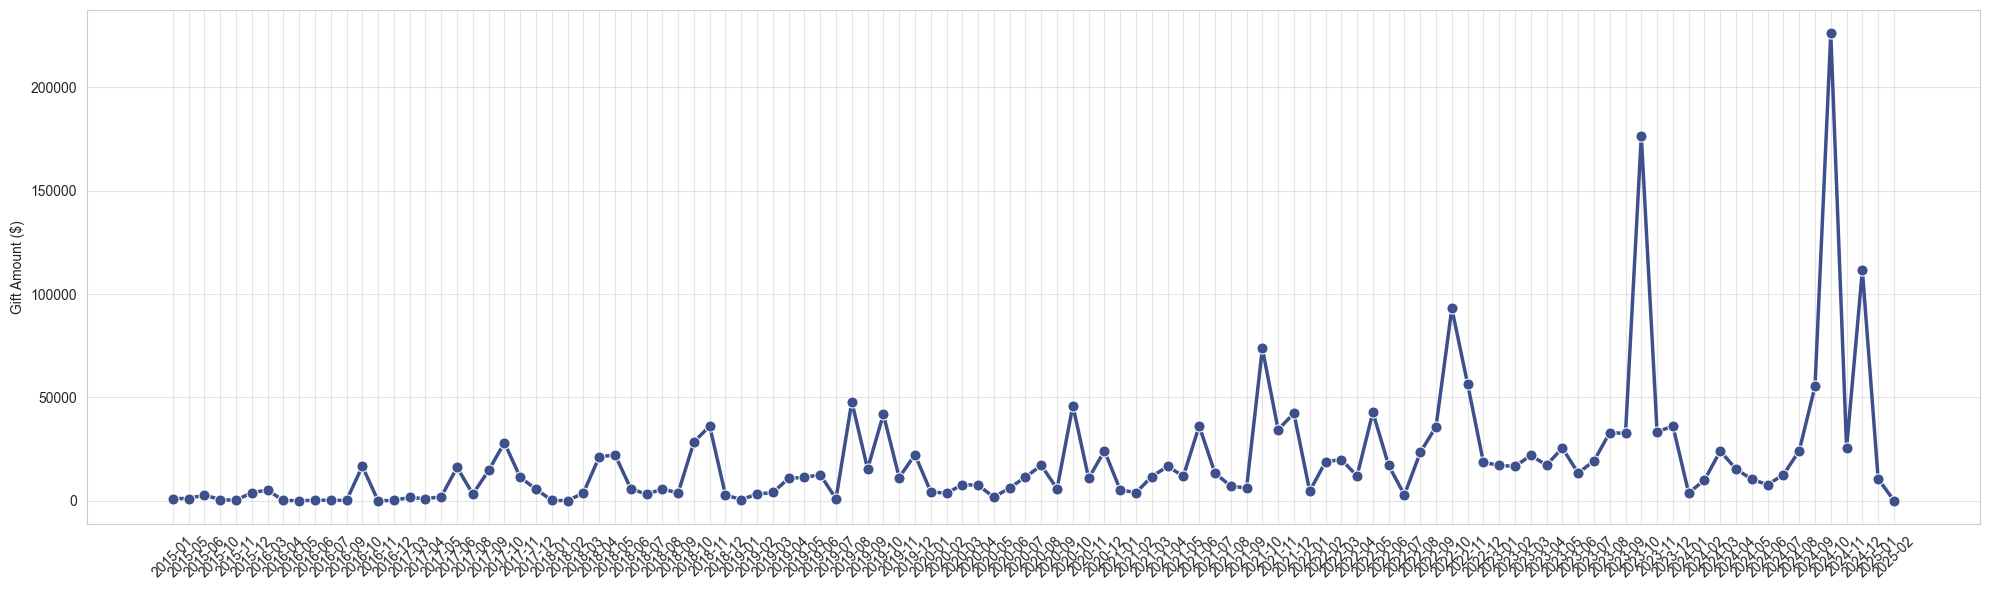

In [13]:
sns.set_style("whitegrid")  # Minimal style
plt.figure(figsize=(20, 6))
sns.lineplot(x="Year_Month", y="Real_Revenue", data=month_data, marker="o", color="#3d508c",  markersize=8, linestyle="-", linewidth=2.5,)
plt.title("", fontweight="bold", fontsize = 15)
plt.xlabel("")
plt.ylabel("Gift Amount ($)", fontweight="light")
plt.xticks(rotation=45)
plt.grid(True, linestyle="-", alpha=0.5)
plt.tight_layout()
plt.show()

In [14]:
# 3. Group and sum revenue
df_decomp = df_loyal[['Real_Revenue', 'Date']].resample('M', on='Date').sum().reset_index()
df_decomp = df_decomp[(df_decomp['Date'] > '2018-01-01') & (df_decomp['Date'] < '2025-01-01')]
df_decomp

/var/folders/qh/3cmsk7s53tdbg86r6lqvjyg40000gn/T/ipykernel_2755/377193476.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_decomp = df_loyal[['Real_Revenue', 'Date']].resample('M', on='Date').sum().reset_index()


,Date,Real_Revenue
36,2018-01-31,313.404681
37,2018-02-28,103.958626
38,2018-03-31,3870.930005
39,2018-04-30,21230.075865
40,2018-05-31,22350.358477
...,...,...
115,2024-08-31,24240.560000
116,2024-09-30,55369.910000
117,2024-10-31,225917.830000
118,2024-11-30,25546.740000


In [15]:
# Make sure it's a Series and the index is datetime
df_decomp = df_decomp.set_index("Date")

# Apply log transformation to handle multiplicative seasonality
#df_decomp['Log_Real_Revenue'] = np.log(df_decomp['Real_Revenue'])

#df_decomp = df_decomp.astype(float)
df_decomp = df_decomp['Real_Revenue']

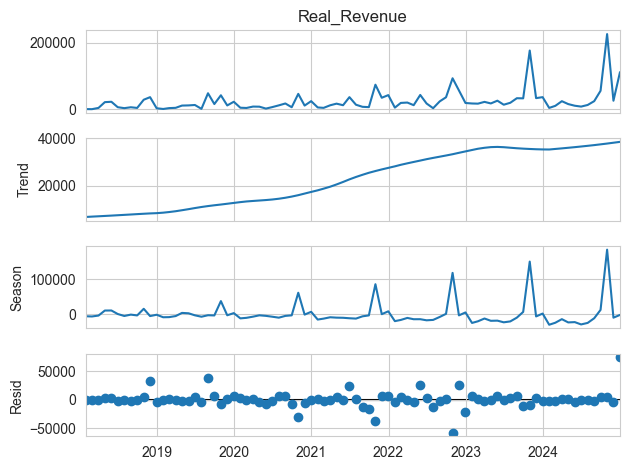

In [16]:
stl = STL(df_decomp, period=12, robust = True)  # or 12, depending on pattern
result = stl.fit()
result.plot()
plt.show()

In [19]:
y = df_decomp.reset_index()

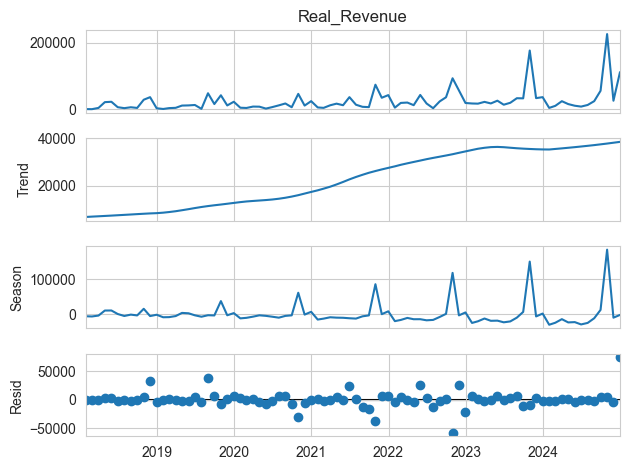

/var/folders/qh/3cmsk7s53tdbg86r6lqvjyg40000gn/T/ipykernel_2755/3479501922.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(y_stl.index[-1] + pd.DateOffset(1), periods=12, freq='M')


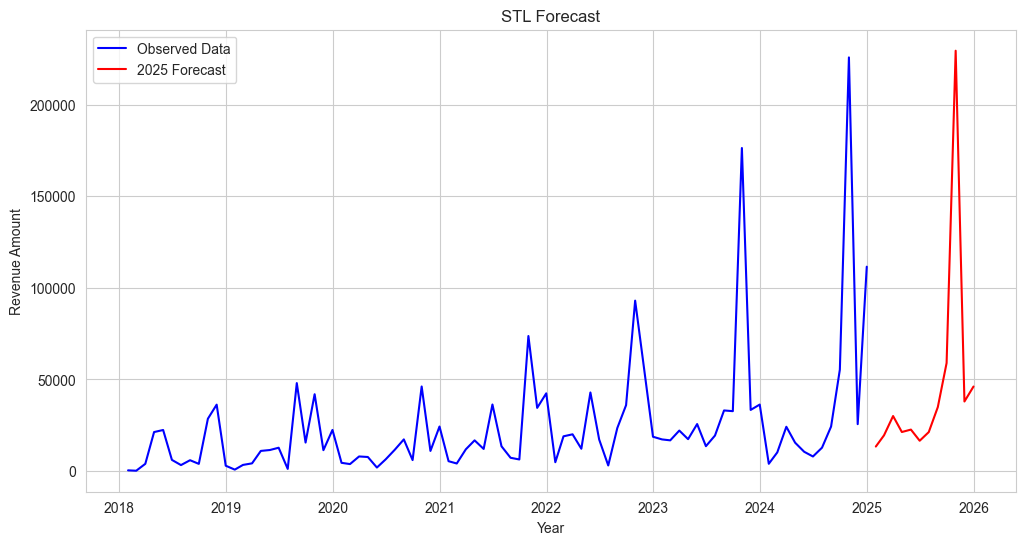

In [21]:
# Load/prepare data (assuming y_ets is your DataFrame)
y_stl = y[['Date', 'Real_Revenue']].set_index('Date')

# Decompose the time series using STL
stl = STL(y_stl['Real_Revenue'], period=12, robust=True)  # Adjust period for seasonality
result = stl.fit()

# Extract components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot STL decomposition
result.plot()
plt.show()

# Forecast the trend (simple linear extrapolation)
trend_forecast = np.poly1d(np.polyfit(range(len(trend.dropna())), trend.dropna(), 1))(
    range(len(trend), len(trend) + 12)
)

# Extend the seasonal component (repeat the last 12 months of seasonality)
seasonal_forecast = seasonal[-12:].values

# Combine trend and seasonal forecasts
forecast_2025 = trend_forecast + seasonal_forecast

# Create forecast index
forecast_index = pd.date_range(y_stl.index[-1] + pd.DateOffset(1), periods=12, freq='M')

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(y_stl.index, y_stl['Real_Revenue'], label='Observed Data', color='blue')
plt.plot(forecast_index, forecast_2025, label='2025 Forecast', color='red')
plt.title('STL Forecast')
plt.xlabel('Year')
plt.ylabel('Revenue Amount')
plt.legend()
plt.grid(True)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/var/folders/qh/3cmsk7s53tdbg86r6lqvjyg40000gn/T/ipykernel_2755/781760281.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(y_ets.index[-1] + pd.DateOffset(1), periods=12, freq='M')


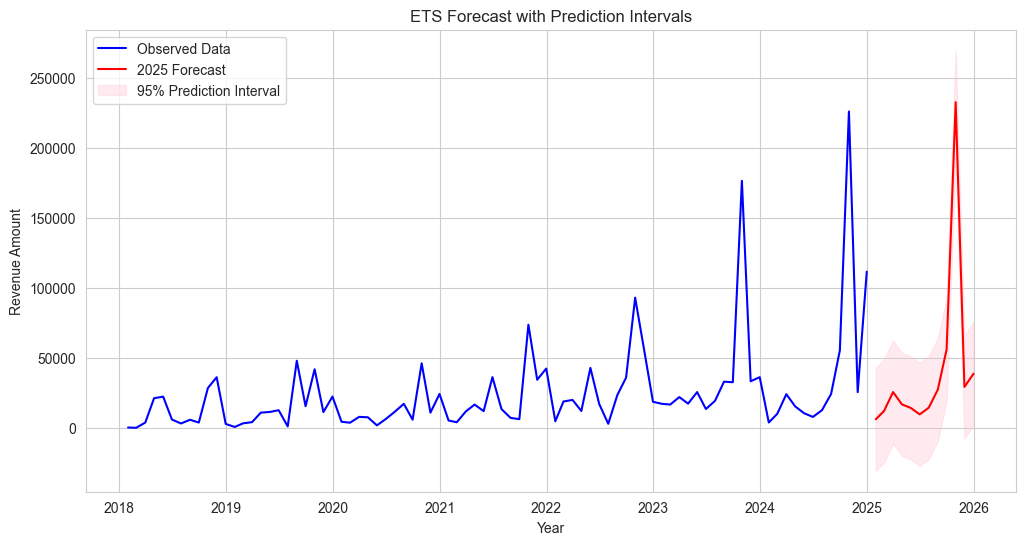

In [23]:
# Load/prepare data (assuming y_ets is your DataFrame)
y_ets = y[['Date', 'Real_Revenue']].set_index('Date')

# Fit ETS with seasonality on the entire dataset
model = ExponentialSmoothing(
    y_ets['Real_Revenue'],
    trend='add',
    seasonal='mul',
    seasonal_periods=12,  # Yearly seasonality
    initialization_method='estimated',
    damped_trend=True
)
ets_model = model.fit()

# Forecast 2025 (12 months into the future)
forecast_2025 = ets_model.forecast(steps=12)  # Forecast for 12 months

# Calculate residuals
residuals = y_ets['Real_Revenue'] - ets_model.fittedvalues

# Estimate the standard deviation of the residuals
residual_std = np.std(residuals)

# Calculate prediction intervals (95% confidence interval)
forecast_index = pd.date_range(y_ets.index[-1] + pd.DateOffset(1), periods=12, freq='M')
lower_bound = forecast_2025 - 1.96 * residual_std
upper_bound = forecast_2025 + 1.96 * residual_std

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_ets.index, y_ets['Real_Revenue'], label='Observed Data', color='blue')
plt.plot(forecast_index, forecast_2025, label='2025 Forecast', color='red')
plt.fill_between(forecast_index, lower_bound, upper_bound, color='pink', alpha=0.3, label='95% Prediction Interval')
plt.title('ETS Forecast with Prediction Intervals')
plt.xlabel('Year')
plt.ylabel('Revenue Amount')
plt.legend()
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### At Risk Segement

In [24]:
df_risk = df[df['Segment'] == 'At Risk']

In [25]:
# 3. Group and sum revenue
df_decomp = df_risk[['Real_Revenue', 'Date']].resample('M', on='Date').sum().reset_index()
df_decomp = df_decomp[(df_decomp['Date'] > '2018-01-01') & (df_decomp['Date'] < '2025-01-01')]
df_decomp

/var/folders/qh/3cmsk7s53tdbg86r6lqvjyg40000gn/T/ipykernel_2755/1022272363.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_decomp = df_risk[['Real_Revenue', 'Date']].resample('M', on='Date').sum().reset_index()


,Date,Real_Revenue
36,2018-01-31,611.521328
37,2018-02-28,6.115213
38,2018-03-31,443.964484
39,2018-04-30,976.354952
40,2018-05-31,7160.339919
...,...,...
115,2024-08-31,626.730000
116,2024-09-30,87.720000
117,2024-10-31,172.810000
118,2024-11-30,0.000000


In [26]:
# Make sure it's a Series and the index is datetime
df_decomp = df_decomp.set_index("Date")

# Apply log transformation to handle multiplicative seasonality
#df_decomp['Log_Real_Revenue'] = np.log(df_decomp['Real_Revenue'])

#df_decomp = df_decomp.astype(float)
df_decomp = df_decomp['Real_Revenue']

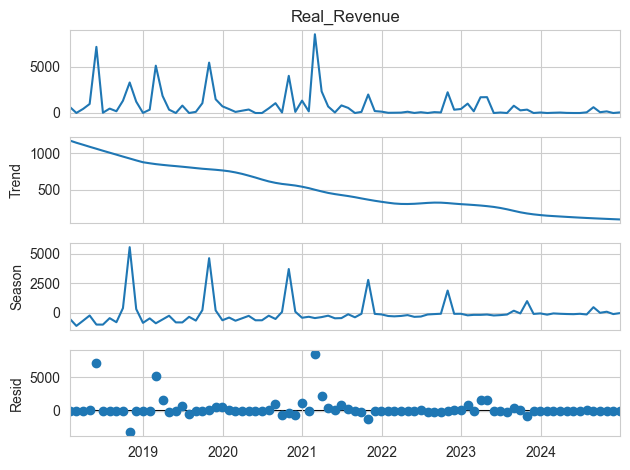

In [27]:
stl = STL(df_decomp, period=12, robust = True)  # or 12, depending on pattern
result = stl.fit()
result.plot()
plt.show()

### Promising Segment

In [28]:
df_potential = df[df['Segment'] == 'Promising']
# 3. Group and sum revenue
df_decomp = df_potential[['Real_Revenue', 'Date']].resample('M', on='Date').sum().reset_index()
df_decomp = df_decomp[(df_decomp['Date'] > '2018-01-01') & (df_decomp['Date'] < '2025-01-01')]
df_decomp

/var/folders/qh/3cmsk7s53tdbg86r6lqvjyg40000gn/T/ipykernel_2755/2968259982.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_decomp = df_potential[['Real_Revenue', 'Date']].resample('M', on='Date').sum().reset_index()


,Date,Real_Revenue
36,2018-01-31,134.534692
37,2018-02-28,134.534692
38,2018-03-31,391.373650
39,2018-04-30,2421.673380
40,2018-05-31,6142.915195
...,...,...
115,2024-08-31,1037.700000
116,2024-09-30,6650.000000
117,2024-10-31,45124.150000
118,2024-11-30,1000.000000


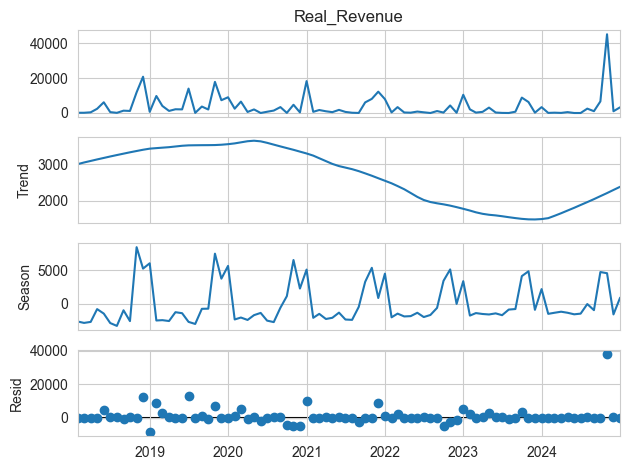

In [29]:
# Make sure it's a Series and the index is datetime
df_decomp = df_decomp.set_index("Date")
df_decomp = df_decomp['Real_Revenue']
stl = STL(df_decomp, period=12, robust = True)  # or 12, depending on pattern
result = stl.fit()
result.plot()
plt.show()

## Survival Analysis

count    6414.000000
mean      177.614437
std       298.566653
min         0.000000
25%        30.000000
50%        31.000000
75%       253.000000
max      3172.000000
Name: Donation_Interval, dtype: float64


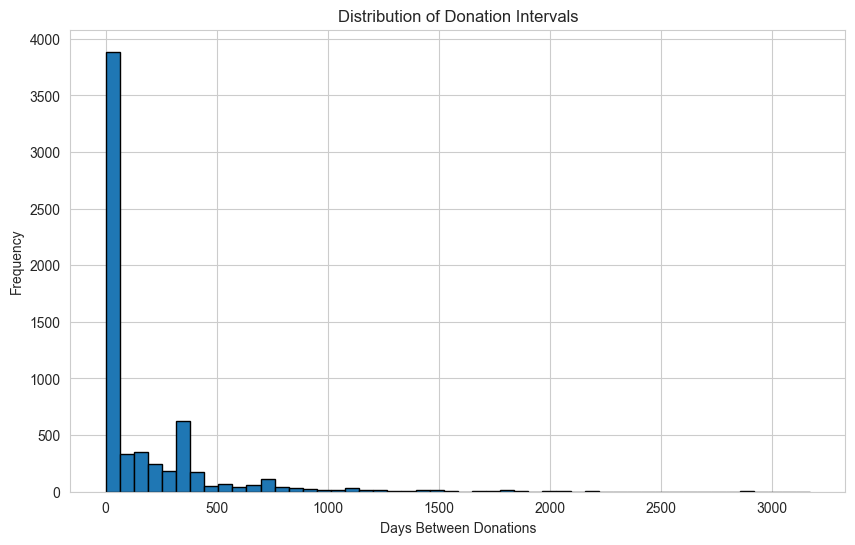

In [30]:
# Sort the data by ID and Date
df_sorted = df.sort_values(by=['ID', 'Date'])

# Calculate the time difference between consecutive donations for each donor
df_sorted['Donation_Interval'] = df_sorted.groupby('ID')['Date'].diff().dt.days

# Analyze the distribution of donation intervals
print(df_sorted['Donation_Interval'].describe())

# Plot the distribution of donation intervals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
df_sorted['Donation_Interval'].dropna().hist(bins=50, edgecolor='black')
plt.title('Distribution of Donation Intervals')
plt.xlabel('Days Between Donations')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [33]:
# Calculate the 90th percentile of donation intervals
churn_threshold = df_sorted['Donation_Interval'].quantile(0.75)
print(f"Churn Threshold (90th Percentile): {churn_threshold} days")

Churn Threshold (90th Percentile): 253.0 days


In [34]:
# Define 'observation_end' (your dataset cutoff date)
observation_end = pd.Timestamp('2025-01-31')

df_survival = df.groupby('ID').agg(
    Last_Donation_Date=('Date', 'max'),
    First_Donation_Date=('Date', 'min'),
    Segment=('Segment', 'first') 
).reset_index()

# Compute duration (in days or months)
df_survival['Duration'] = (df_survival['Last_Donation_Date'] - df_survival['First_Donation_Date']).dt.days

# Churn definition: no donation in past 12 months
df_survival['Churned'] = ((observation_end - df_survival['Last_Donation_Date']).dt.days > churn_threshold).astype(int)

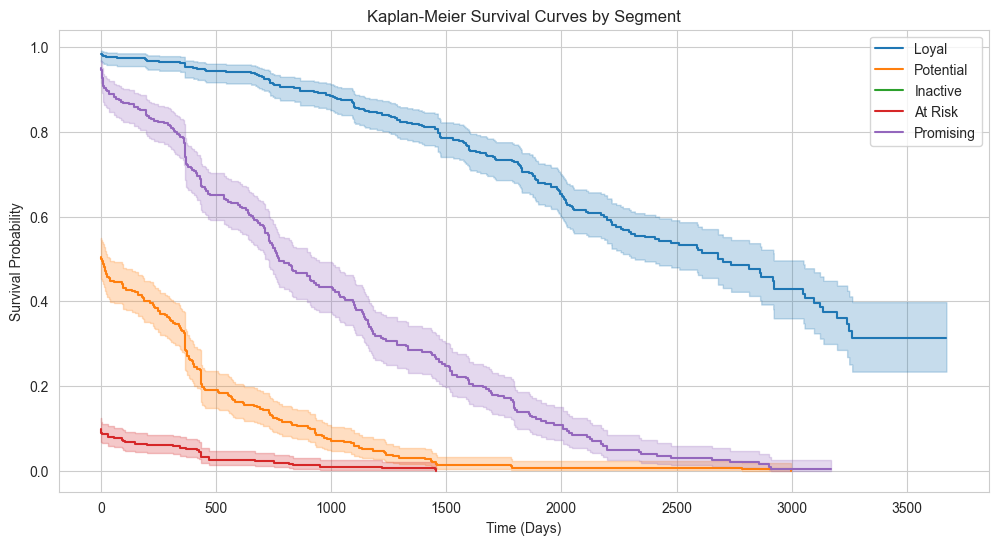

In [35]:
# Initialize Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Plot survival curves for each segment
plt.figure(figsize=(12, 6))
for segment in df_survival['Segment'].unique():
    segment_data = df_survival[df_survival['Segment'] == segment]
    kmf.fit(segment_data['Duration'], event_observed=segment_data['Churned'], label=segment)
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curves by Segment')
plt.xlabel('Time (Days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# Extract survival probabilities for each segment
summary = {}
for segment in df_survival['Segment'].unique():
    segment_data = df_survival[df_survival['Segment'] == segment]
    kmf.fit(segment_data['Duration'], event_observed=segment_data['Churned'])
    survival_table = kmf.survival_function_at_times([30, 90, 180, 365])  # Survival at 30, 90, 180, 365 days
    summary[segment] = survival_table

# Convert to a DataFrame for easier viewing
summary_df = pd.DataFrame(summary)
print(summary_df)

        Loyal  Potential  Inactive   At Risk  Promising
30   0.976452   0.458105       0.0  0.083240   0.895562
90   0.974262   0.441139       0.0  0.076837   0.871451
180  0.974262   0.410598       0.0  0.064031   0.850784
365  0.952088   0.288437       0.0  0.054426   0.739612


In [37]:
# Calculate median survival time for each segment
median_survival = {}
for segment in df_survival['Segment'].unique():
    segment_data = df_survival[df_survival['Segment'] == segment]
    kmf.fit(segment_data['Duration'], event_observed=segment_data['Churned'])
    median_survival[segment] = kmf.median_survival_time_

# Convert to a DataFrame for easier viewing
median_survival_df = pd.DataFrame(list(median_survival.items()), columns=['Segment', 'Median Survival Time'])
print(median_survival_df)

     Segment  Median Survival Time
0      Loyal                2701.0
1  Potential                   1.0
2   Inactive                   0.0
3    At Risk                   0.0
4  Promising                 772.0
